/home/edu/miniconda3/envs/causal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


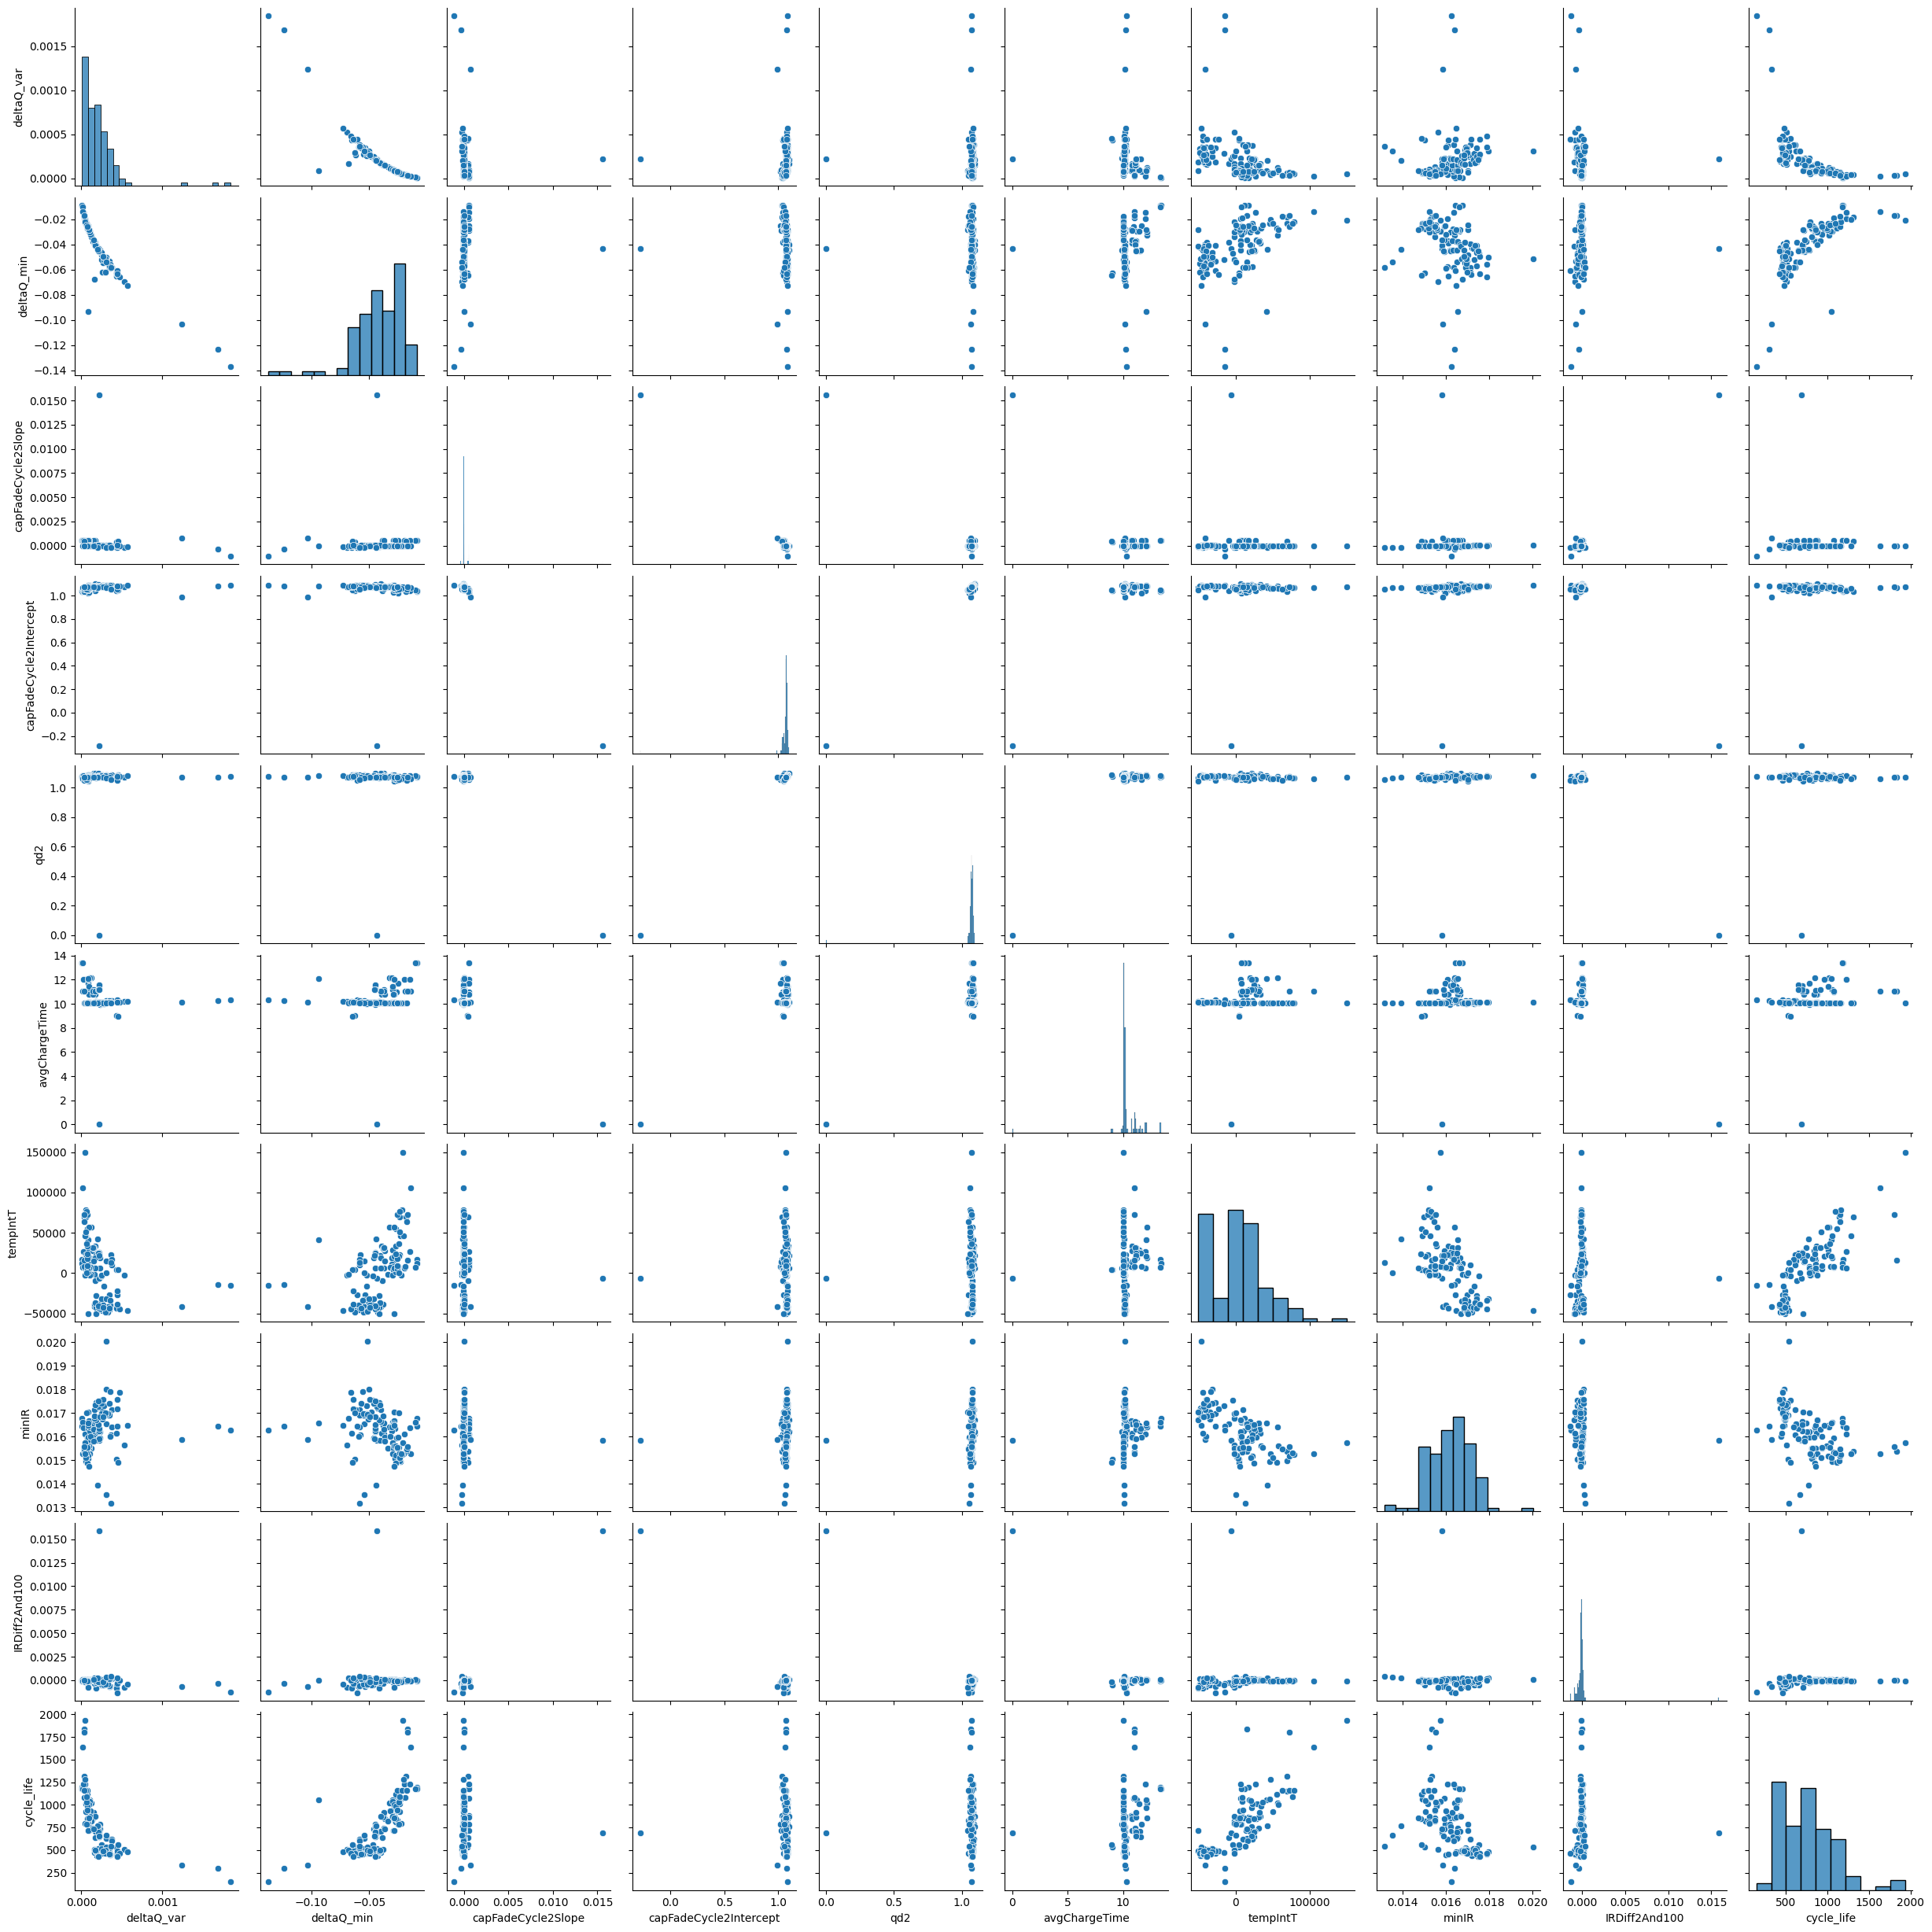

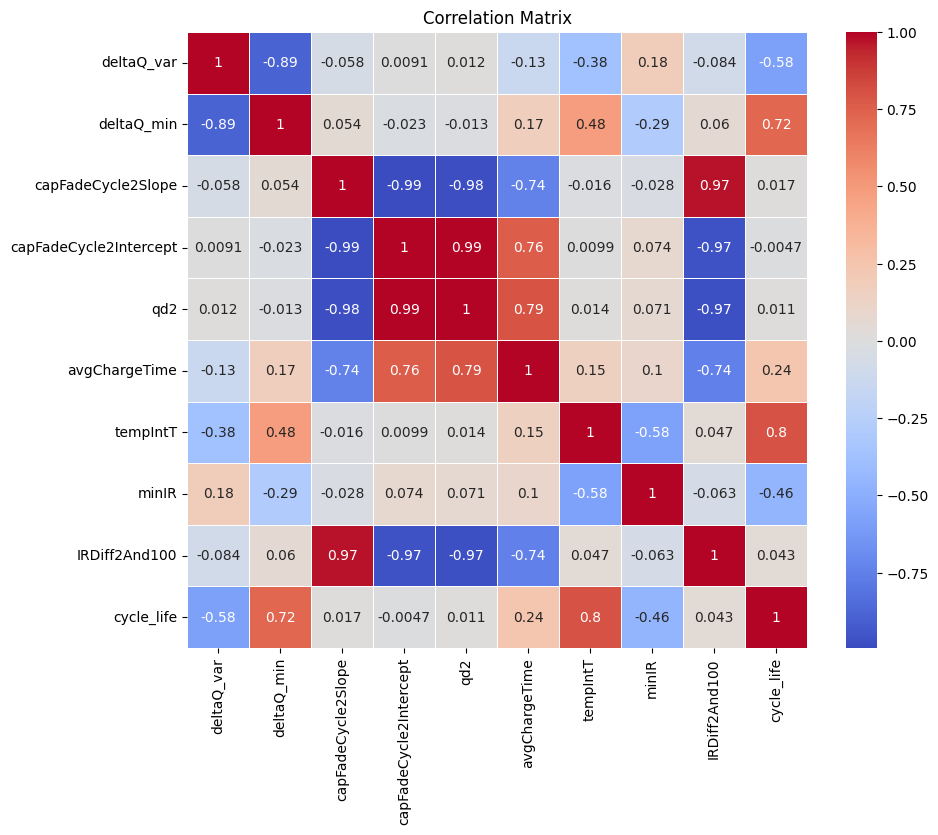

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap
from pre_processing import *


warnings.filterwarnings("ignore")

data = pd.read_csv("data/BatteryFeatures.csv")

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the pairplot
sns.pairplot(data)
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

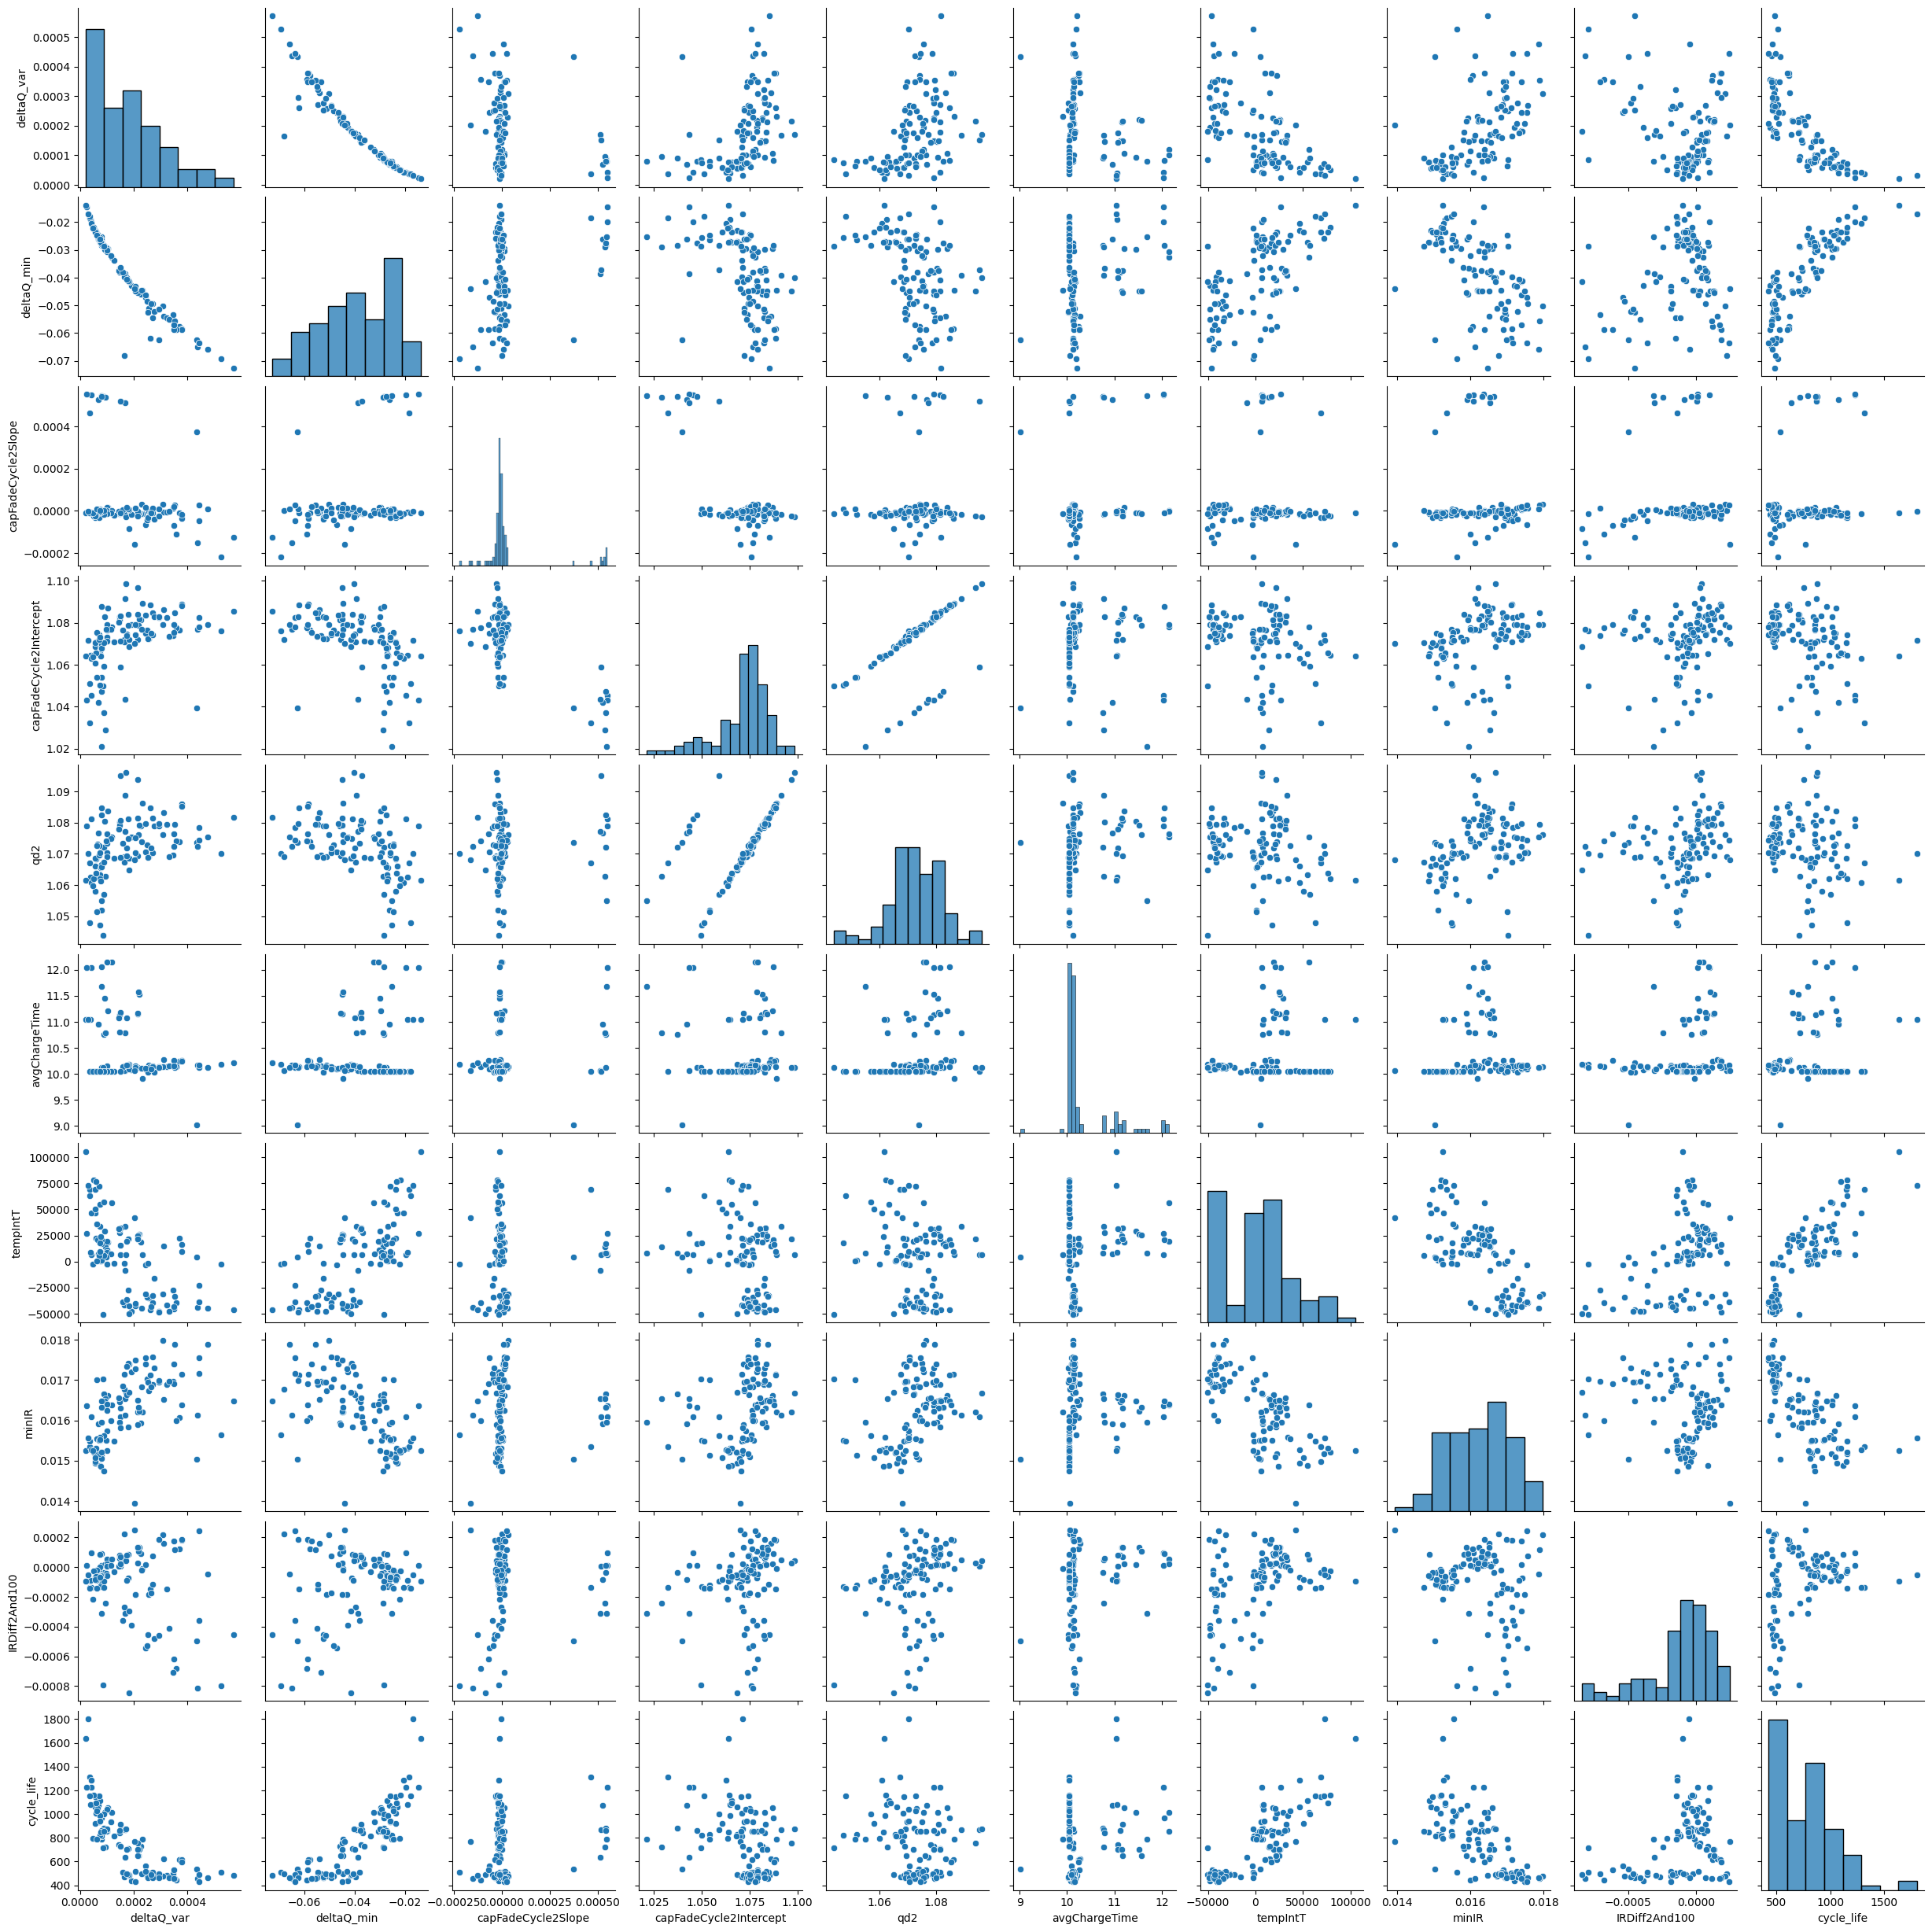

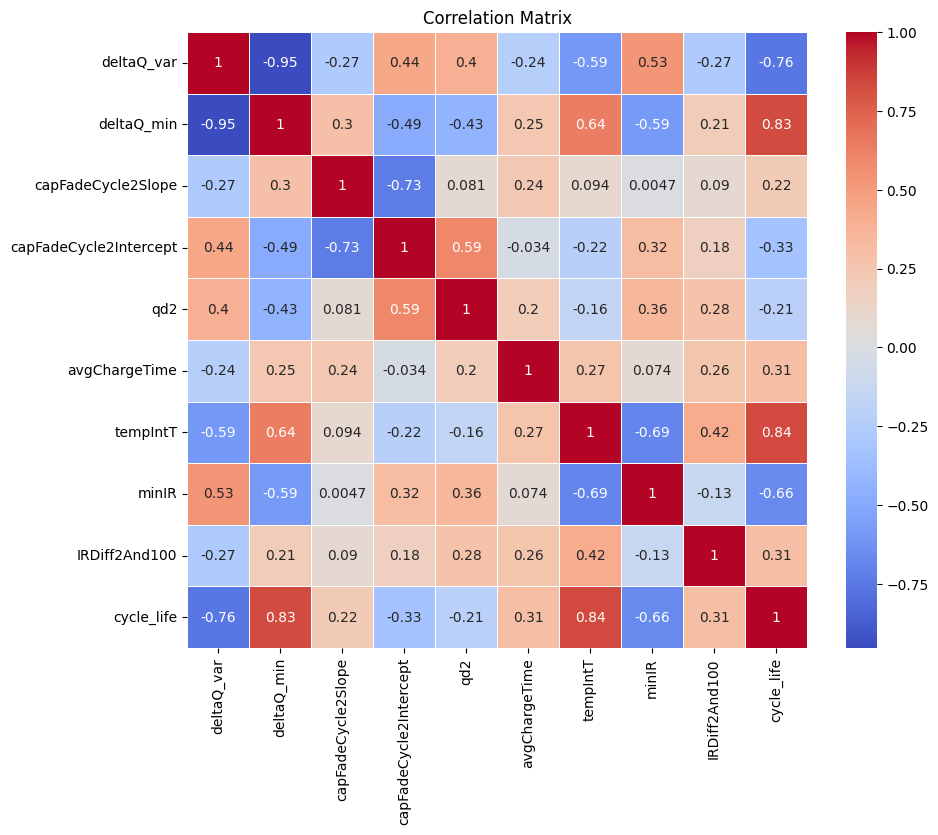

In [2]:
# Apply the function to remove outliers from the dataset
cleaned_data = remove_outliers_chi_squared(data)

# Calculate the correlation matrix
correlation_matrix_clean = cleaned_data.corr()

# Plot the pairplot
sns.pairplot(cleaned_data)
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_clean, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

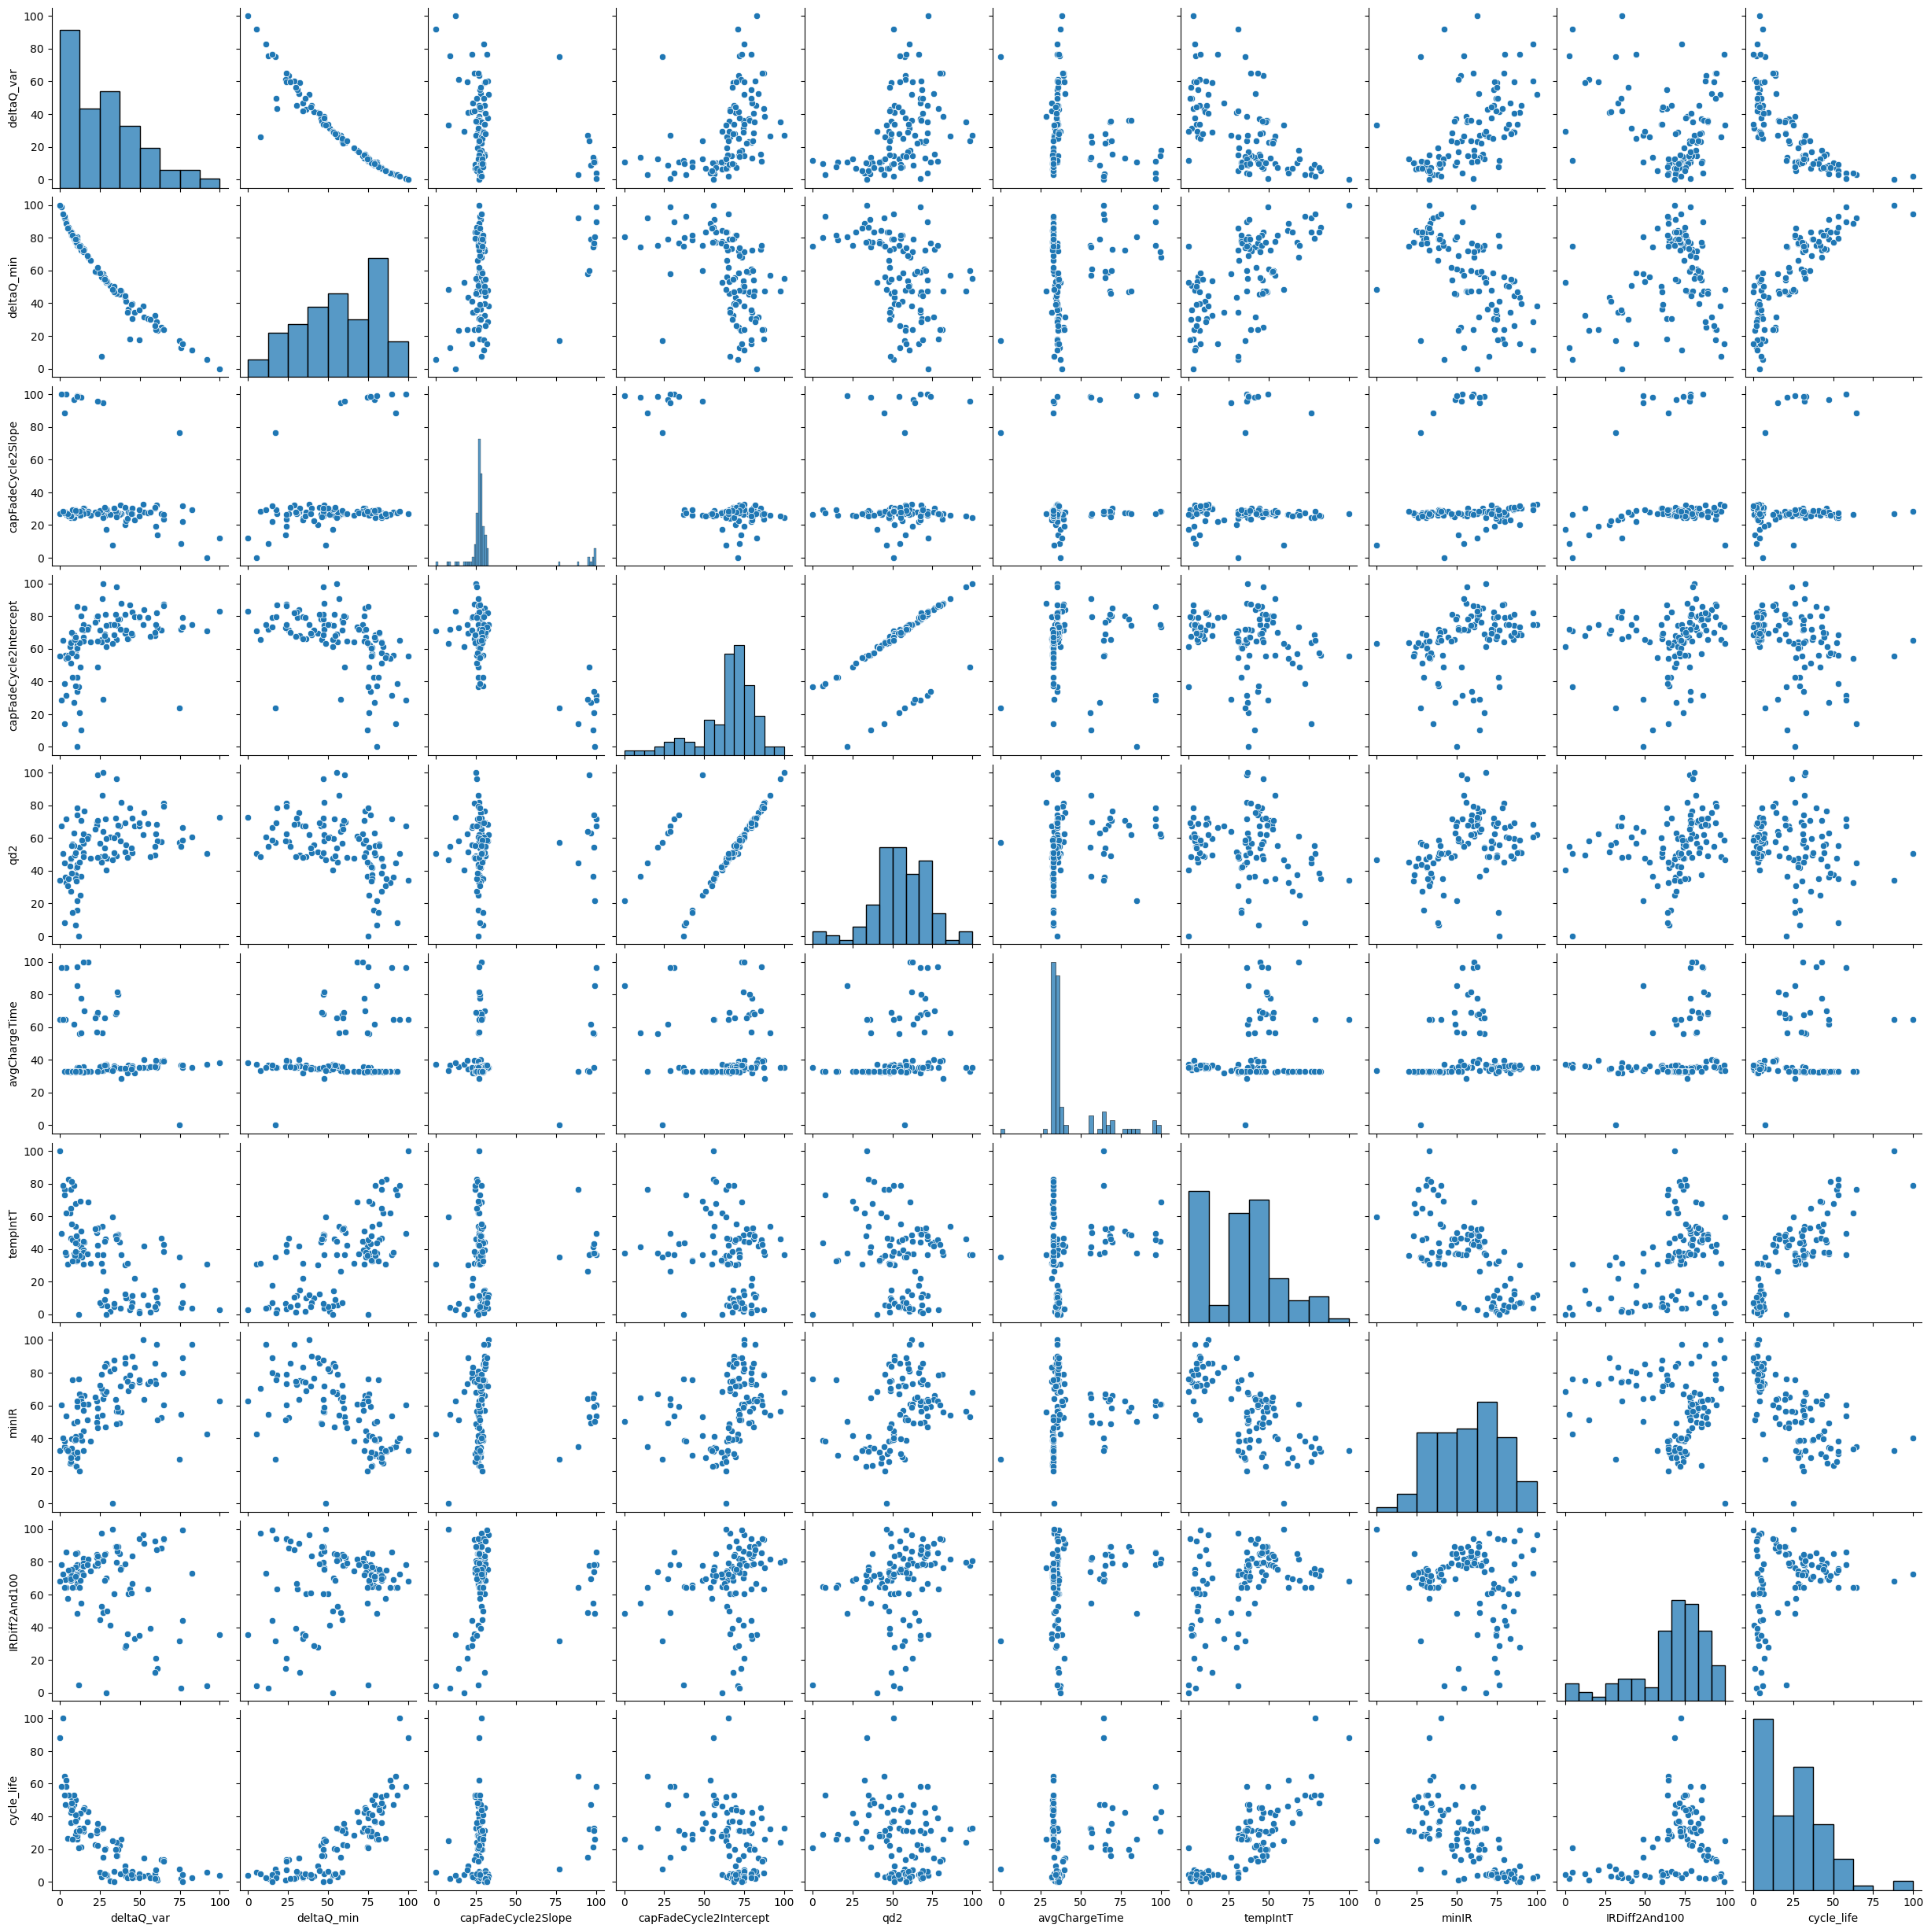

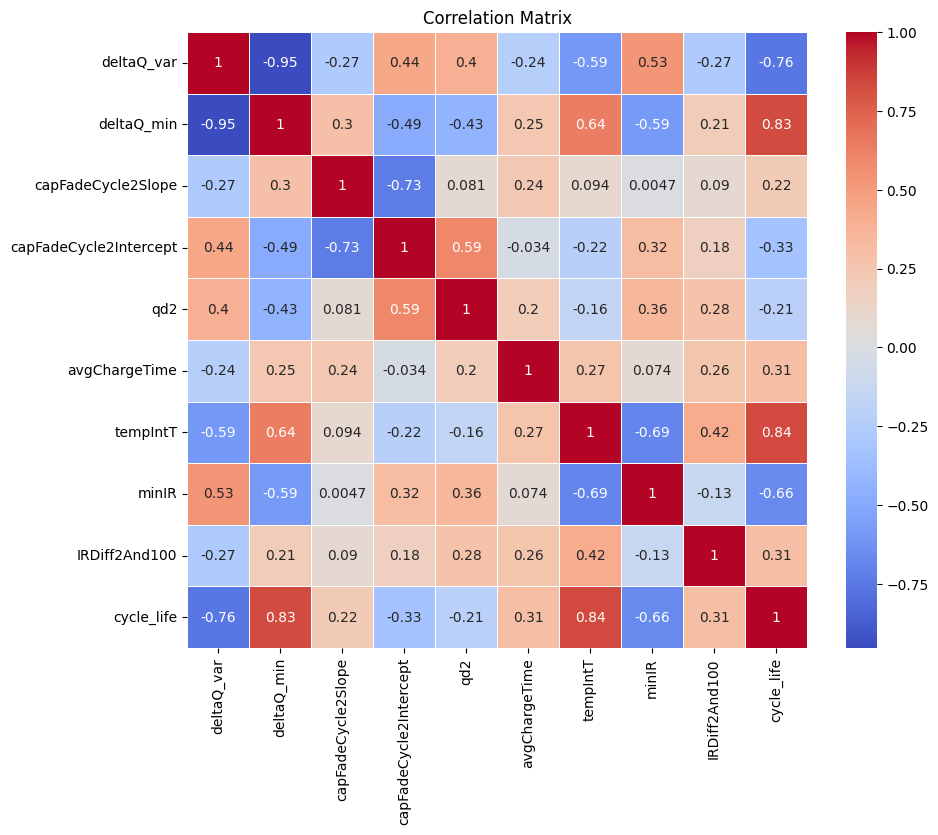

In [3]:
# Apply the normalization function to the cleaned dataset
normalized_data = normalize_data(cleaned_data)

correlation_matrix_normal = normalized_data.corr()

# Plot the pairplot
sns.pairplot(normalized_data)
plt.show()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_normal, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [4]:
def normalized_root_mean_squared_error(original, reconstructed):
        mse = mean_squared_error(original, reconstructed)
        rmse = np.sqrt(mse)
        norm_rmse = rmse / (np.max(original) - np.min(original))
        return norm_rmse
    

In [5]:
def plot_quality_vs_complexity(normalized_data):

    loss_array = []
    D_array = []
    num_bins_max = 100

    for bins in range(1,num_bins_max + 1):

        discretized_data = discretize_data_with_lower_bounds(normalized_data,bins = bins)
        
        #loss = normalized_root_mean_squared_error(normalized_data, discretized_data)
        loss = np.linalg.norm(normalized_data - discretized_data,1)
    
        unique_values = {col: discretized_data[col].unique() for col in discretized_data.columns}
        
        D = 0
        
        for i in unique_values:
            D += len(unique_values[i])

        loss_array.append(loss)
        D_array.append(D)

    D_array = np.array(D_array)
    loss_array = np.array(loss_array)
    
    #D_array = D_array / np.max(D_array)
    #loss_array = loss_array / np.max(loss_array)

    return D_array,loss_array

D_array,loss_array = plot_quality_vs_complexity(normalized_data)

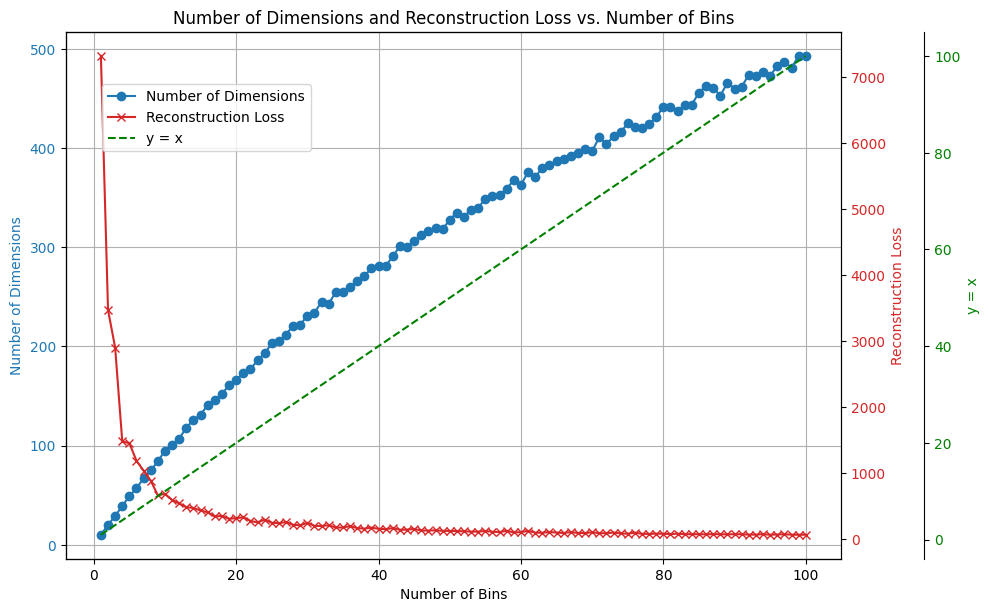

In [6]:
bins = [i for i in range(1,101)]

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for the number of dimensions
ax1.set_xlabel('Number of Bins')
ax1.set_ylabel('Number of Dimensions', color='tab:blue')
ax1.plot(bins, D_array, label='Number of Dimensions', color='tab:blue', marker='o')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a second y-axis for the reconstruction loss
ax2 = ax1.twinx()
ax2.set_ylabel('Reconstruction Loss', color='tab:red')
ax2.plot(bins, loss_array, label='Reconstruction Loss', color='tab:red', marker='x')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Plot y = x line
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # Move the third axis outwards
ax3.plot(bins, bins, label='y = x', color='green', linestyle='--')
ax3.set_ylabel('y = x', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Add legends
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Number of Dimensions and Reconstruction Loss vs. Number of Bins')
plt.show()
